## ZTF - Attribution
In this notebook, we run attribution on the two weeks of ZTF data from 2018 using a more recent orbit catalog available in 2021. We also update the ssnamenr provided by ZTF to be compatible with 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time

%matplotlib inline

import thor

from thor import __version__
print("THOR version: {}".format(__version__))

THOR version: 1.1.dev199+g1c54766.d20210401


In [2]:
preprocessed_observations = pd.read_csv(
    "/mnt/data/projects/thor/thor_data/ztf/preprocessed_observations.csv",
    index_col=False,
    dtype={
        "obs_id" : str
    }
)
preprocessed_associations = pd.read_csv(
    "/mnt/data/projects/thor/thor_data/ztf/preprocessed_associations.csv",
    index_col=False,
    dtype={
        "obs_id" : str
    }
)

In [3]:
from thor.utils import getMPCOrbitCatalog
from thor.utils import readMPCOrbitCatalog

#getMPCOrbitCatalog() Last run on April 20th 2021
mpcorb = readMPCOrbitCatalog()

In [4]:
last_observed = mpcorb["last_obs"].str.split("-", expand=True)
cols = ["year", "month", "day"]
last_observed.rename(columns={i : n for i, n in enumerate(cols)}, inplace=True)
for c in cols:
    last_observed[c] = last_observed[c].astype(int)

mask = (
    # Remove orbits that have an arc length less than 10 days
    (mpcorb["arc_days"].isna() | (mpcorb["arc_days"] >= 10)) 
    
    # Remove orbits that have had their eccentricity values set rather than fit 
    & (~mpcorb["uncertainty_param"].isin(["E"])) 
    
    # Remove orbits that have not been observed in the current century
    & (last_observed["year"] >= 2000)
)

print(len(mpcorb))
print(len(mpcorb[mask]))

1075888
1044313


In [5]:
from thor.orbits import Orbits

mpc_orbits = Orbits.fromMPCOrbitCatalog(mpcorb[mask])

orbit_file = "/mnt/data/projects/thor/thor_data/ztf/MPCORB_20210420.csv"
if not os.path.exists(orbit_file):
    mpcorb[mask].to_csv(
        orbit_file, 
        index=False
    )

In [6]:
from thor.orbits import attributeObservations

attribution_file = "/mnt/data/projects/thor/thor_data/ztf/attributions_20210420_3arcsec.csv"
if not os.path.exists(attribution_file):
    attributions = attributeObservations(
        mpc_orbits,
        preprocessed_observations,
        eps=3/3600,
        include_probabilistic=True,
        orbits_chunk_size=100,
        observations_chunk_size=200000,
        threads=60,
        backend='PYOORB',
        backend_kwargs={},
    )
    attributions.to_csv(attribution_file, index=False)
else:
    attributions = pd.read_csv(
        attribution_file, 
        index_col=False, 
        low_memory=False,
        dtype={
            "obs_id" : str,
        }
    )

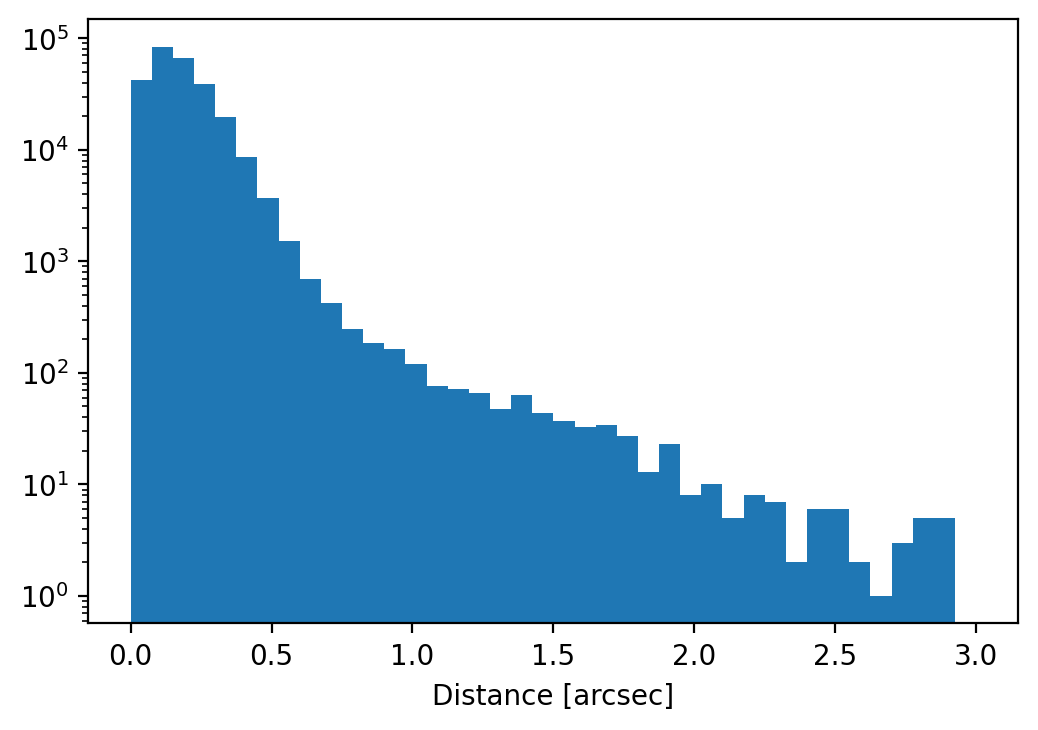

In [7]:
fig, ax = plt.subplots(1, 1, dpi=200)
bins, bin_edges, bars = ax.hist(attributions["distance"].values * 3600, range=(0, 3), bins=40)
ax.set_xlabel("Distance [arcsec]")
ax.set_yscale("log")

In [8]:
attributions.sort_values(
    by=["obs_id", "distance"], 
    ascending=[True, True],
    inplace=True,
    ignore_index=True
)
attributions.drop_duplicates(
    subset=["obs_id"], 
    keep="first",
    inplace=True,
    ignore_index=True
)

In [11]:
attributions[(attributions["distance"] * 3600) <= 1]

,orbit_id,obs_id,mjd_utc,distance,residual_ra_arcsec,residual_dec_arcsec,chi2,probability,mahalanobis_distance
0,27310,610130480115015030,58364.130486,0.000055,0.191133,-0.052943,3.933481,0.332598,2.201643
1,14935,610130480115015043,58364.130486,0.000049,0.099153,-0.146610,3.132584,0.398454,1.840328
2,2159,610130480515015028,58364.130486,0.000038,0.083303,0.109320,1.889009,0.487691,1.436148
3,2421,610130480515015038,58364.130486,0.000020,0.061665,-0.033719,0.493953,0.680377,0.770216
4,1768,610130480915015022,58364.130486,0.000045,0.161712,-0.008904,2.622993,0.404256,1.811414
...,...,...,...,...,...,...,...,...,...
266789,253109,624525845215015002,58378.525845,0.000085,0.163875,-0.257433,9.312675,0.178898,3.441876
266790,43423,624525845615015001,58378.525845,0.000079,0.199944,0.201718,8.066767,0.179317,3.437206
266791,175469,624525845815015033,58378.525845,0.000031,0.065187,0.088565,1.209314,0.534090,1.254383
266792,9816,624525845915015050,58378.525845,0.000024,0.063718,0.057155,0.732664,0.594314,1.040694


In [12]:
attributions[(attributions["distance"] * 3600) >= 1]

,orbit_id,obs_id,mjd_utc,distance,residual_ra_arcsec,residual_dec_arcsec,chi2,probability,mahalanobis_distance
168,43631,610135754515015000,58364.135752,0.000318,0.927573,-0.669262,130.830245,3.162217e-03,11.512964
225,2018 FO5,610160860515015009,58364.160868,0.000424,1.405790,-0.598949,233.498449,1.599408e-04,17.481414
309,2013 UL,610167455915015020,58364.167454,0.000378,1.149656,0.731338,185.656336,1.099351e-03,13.626070
319,2018 FO5,610171350515015063,58364.171354,0.000435,1.462720,-0.563543,245.713064,1.238485e-04,17.992902
402,2018 FO5,610203850515015056,58364.203854,0.000437,1.458439,-0.590245,247.543210,1.216559e-04,18.028628
...,...,...,...,...,...,...,...,...,...
257035,2018 WE3,624422301715015004,58378.422303,0.000693,1.808548,-1.716064,621.571996,3.993916e-12,52.492481
259152,468684,624443274715015001,58378.443276,0.000279,0.040055,-1.005128,101.188607,6.539015e-03,10.059937
259160,2018 RX,624443720815015004,58378.443727,0.000362,0.817018,-1.016236,170.025309,1.388067e-03,13.159687
261811,2005 FG,624452404715015012,58378.452407,0.000360,-1.250224,0.335384,167.554295,1.337724e-03,13.233572


In [13]:
preprocessed_associations_2021 = preprocessed_associations.merge(
    attributions, 
    on="obs_id", 
    how="left"
)
preprocessed_associations_2021.rename(
    columns={
        "obj_id" : "obj_id_prev",
        "orbit_id" : "obj_id"
    },
    inplace=True
)
# Count the number of observations for each object in 2018 
occurences_prev = preprocessed_associations["obj_id"].value_counts().to_frame(name="num_obs_prev")
occurences_prev.reset_index(inplace=True)
occurences_prev.rename(columns={"index" : "obj_id_prev"}, inplace=True)
preprocessed_associations_2021 = preprocessed_associations_2021.merge(
    occurences_prev, 
    on="obj_id_prev", 
    how="left"
)

# Count the number of observations for each object in 2021 that were associated
occurences = preprocessed_associations_2021["obj_id"].value_counts().to_frame(name="num_obs")
occurences.reset_index(inplace=True)
occurences.rename(columns={"index" : "obj_id"}, inplace=True)
preprocessed_associations_2021 = preprocessed_associations_2021.merge(
    occurences, 
    on="obj_id", 
    how="left"
)

In [14]:
# Observations that were unassociated in 2018 and unassociated in 2021 will inherit the 'unknown' obj_ids of 2018 
unknown_2021 = (preprocessed_associations_2021["obj_id_prev"].str.contains("^u[0-9]{8}", regex=True)) & (preprocessed_associations_2021["obj_id"].isna())
preprocessed_associations_2021.loc[unknown_2021, "obj_id"] = preprocessed_associations_2021[unknown_2021]["obj_id_prev"].values
print(len(preprocessed_associations_2021[unknown_2021]))

560400


In [15]:
# Observations that were associated in 2018 but unassociated in 2021 will inherit the 2018 obj_ids
unknown_2021_known_2018 = (~preprocessed_associations_2021["obj_id_prev"].str.contains("^u[0-9]{8}", regex=True)) & (preprocessed_associations_2021["obj_id"].isna())
preprocessed_associations_2021.loc[unknown_2021_known_2018, "obj_id"] = preprocessed_associations_2021[unknown_2021_known_2018]["obj_id_prev"].values
print(len(preprocessed_associations_2021[unknown_2021_known_2018 & (preprocessed_associations_2021["num_obs"] >= 5)]))
print(len(preprocessed_associations_2021[unknown_2021_known_2018]))

0
352


In [16]:
# Observations that were unassociated in 2018 but associated in 2021 will inherit the 2021 obj_ids
known_2021_unknown_2018 = (preprocessed_associations_2021["obj_id_prev"].str.contains("^u[0-9]{8}", regex=True)) & (~preprocessed_associations_2021["obj_id"].str.contains("^u[0-9]{8}", regex=True))
#preprocessed_associations_2021.loc[known_2021_unknown_2018, "obj_id"] = preprocessed_associations_2021[known_2021_unknown_2018]["obj_id_prev"].values

In [17]:
mask = (
    (~preprocessed_associations_2021["obj_id_prev"].str.contains("^u[0-9]{8}", regex=True)) 
    & (~preprocessed_associations_2021["obj_id"].str.contains("^u[0-9]{8}", regex=True)) 
    & (preprocessed_associations_2021["num_obs"] != preprocessed_associations_2021["num_obs_prev"])
    & (preprocessed_associations_2021["obj_id_prev"] != preprocessed_associations_2021["obj_id"])
)
preprocessed_associations_2021[mask]

,obs_id,obj_id_prev,obj_id,mjd_utc,distance,residual_ra_arcsec,residual_dec_arcsec,chi2,probability,mahalanobis_distance,num_obs_prev,num_obs
19752,610274952515015019,2001 QA143,523805,58364.274954,0.000255,0.621478,0.673678,84.007647,0.009128,9.392909,10,12.0
27470,610337951615015012,2005 TP151,525883,58364.337951,0.000061,0.130055,-0.177234,4.832622,0.326523,2.238507,4,7.0
29759,610386050915015012,173375,2018 RM31,58364.386053,0.000014,0.042033,-0.029047,0.261050,0.774039,0.512265,2,6.0
196561,611312082315015025,2007 TF79,527150,58365.312083,0.000121,-0.387173,-0.200001,18.990351,0.112588,4.368033,3,2.0
196664,611312083715015002,2012 XG30,2018 MN11,58365.312083,0.000054,0.112808,-0.156951,3.735945,0.380424,1.932938,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
806534,624386995115015024,381244,2015 BY150,58378.386991,0.000099,-0.232782,0.270738,12.748645,0.166886,3.580889,4,1.0
807696,624389273315015016,2008 RG149,528281,58378.389271,0.000075,-0.246689,-0.108312,7.258701,0.258617,2.704817,2,6.0
807784,624389274315015010,2008 YZ126,2005 QT198,58378.389271,0.000118,-0.359993,-0.223359,17.948403,0.119510,4.248717,3,2.0
814477,624431775315015015,2014 LT32,533685,58378.431771,0.000014,0.045393,-0.021506,0.252306,0.765338,0.534875,1,2.0


In [18]:
mask = (
    (~preprocessed_associations_2021["obj_id_prev"].str.contains("^u[0-9]{8}", regex=True)) 
    & (~preprocessed_associations_2021["obj_id"].str.contains("^u[0-9]{8}", regex=True)) 
    & (preprocessed_associations_2021["obj_id_prev"] != preprocessed_associations_2021["obj_id"])
)
preprocessed_associations_2021[mask]

,obs_id,obj_id_prev,obj_id,mjd_utc,distance,residual_ra_arcsec,residual_dec_arcsec,chi2,probability,mahalanobis_distance,num_obs_prev,num_obs
2540,610145370015015040,2012 OD1,523664,58364.145370,0.000059,-0.208536,0.032952,4.457299,0.262997,2.671226,75,75.0
2552,610145841615015109,2009 HE82,528991,58364.145845,0.000024,0.041499,-0.076768,0.761555,0.612902,0.979100,34,34.0
2574,610146454715015011,2002 OS4,523595,58364.146458,0.000091,-0.297599,-0.136820,10.728472,0.148010,3.820955,81,81.0
2916,610147534715015030,2002 OS4,523595,58364.147535,0.000096,-0.312742,-0.148789,11.994565,0.133081,4.033600,81,81.0
2983,610149612915015082,2009 HE82,528991,58364.149618,0.000061,0.206385,-0.073191,4.795164,0.211237,3.109550,34,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...
821085,624476740515015005,2009 QD11,529062,58378.476748,0.000059,0.192395,-0.088061,4.477076,0.319832,2.279922,2,2.0
821109,624476742015015011,2005 UW441,526101,58378.476748,0.000041,0.117342,0.087708,2.146180,0.456253,1.569418,2,2.0
821110,624476746015015007,2009 QD43,529080,58378.476748,0.000063,-0.024507,0.224275,5.089987,0.322978,2.260344,2,2.0
822909,624488844515015018,2012 QV14,531321,58378.488843,0.000134,0.403052,0.265212,23.278824,0.049232,6.022420,7,7.0


In [19]:
changed = preprocessed_associations_2021[mask]
changed = changed[["obj_id_prev", "obj_id"]].groupby(by=["obj_id_prev", "obj_id"]).size().to_frame(name="occurrences")
changed.reset_index(inplace=True)
changed.sort_values(by=['occurrences', 'obj_id'], ignore_index=True, inplace=True, ascending=[False, True])
changed = changed.merge(
    preprocessed_associations_2021.drop_duplicates(subset=["obj_id_prev", "obj_id"])[["obj_id_prev", "obj_id", "num_obs_prev", "num_obs"]], 
    on=["obj_id_prev", "obj_id"], 
    how="left"
)

In [21]:
#prev_obj_id, obj_id = "235516", "541119"
#prev_obj_id, obj_id = "235392", "2014 WV346"
#prev_obj_id, obj_id = "2011 ST280", "530671"
#prev_obj_id, obj_id = "2007 TF79", "527150"
prev_obj_id, obj_id = "422709", "2018 RR33" # interesting
#prev_obj_id, obj_id = "27494", "2016 DX12"
#prev_obj_id, obj_id = "2013 WL45", "532759" # example of something fixed



preprocessed_associations_2021[((preprocessed_associations_2021["obj_id_prev"] == prev_obj_id) | (preprocessed_associations_2021["obj_id"] == obj_id))]

,obs_id,obj_id_prev,obj_id,mjd_utc,distance,residual_ra_arcsec,residual_dec_arcsec,chi2,probability,mahalanobis_distance,num_obs_prev,num_obs
29986,610386054115015002,u00025490,2018 RR33,58364.386053,0.000089,0.306718,-0.096403,10.336913,0.200337,3.215513,1,5.0
280561,613377014115015020,u00243999,2018 RR33,58367.377014,0.000050,0.170118,0.062793,3.288294,0.403788,1.813733,1,5.0
289575,613436894315015019,422709,422709,58367.436898,0.000051,-0.175231,-0.058457,3.412323,0.396777,1.848760,6,5.0
417110,616395594215015025,422709,422709,58370.395590,0.000062,-0.021301,-0.223381,5.035268,0.325635,2.243957,6,5.0
581345,619379204715015004,u00438508,2018 RR33,58373.379201,0.000076,0.226779,0.152016,7.453789,0.255235,2.731144,1,5.0
581505,619379204215015032,422709,422709,58373.379201,0.000064,-0.213564,0.084646,5.277435,0.316823,2.298826,6,5.0
711184,622331434715015025,422709,422709,58376.331435,0.000040,-0.048054,0.134415,2.037645,0.489785,1.427579,6,5.0
711215,622331434715015024,u00517946,2018 RR33,58376.331435,0.000035,0.062846,0.108761,1.577857,0.533563,1.256355,1,5.0
723977,622414384715015022,422709,2018 RR33,58376.414387,0.000046,0.116938,0.114706,2.683193,0.440728,1.638653,6,5.0
724084,622414384715015020,422709,422709,58376.414387,0.000006,0.008494,0.018513,0.041488,0.903159,0.203713,6,5.0


In [22]:
preprocessed_associations_2021[["obs_id", "obj_id_prev", "obj_id"]].to_csv(
    "/mnt/data/projects/thor/thor_data/ztf/preprocessed_associations_20210420_3arcsec.csv",
    index=False
)